In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

### Import Libs

In [2]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
import nltk
nltk.download('all')
from nltk.tokenize import word_tokenize
from tqdm import tqdm


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloadin

In [3]:
cd /content/drive/MyDrive/Dataset/English_Assamese

/content/drive/MyDrive/Dataset/English_Assamese


### Load the dataset

In [4]:
text_english = pd.read_table('train.en',names = ['eng'])
text_assamese = pd.read_table('train.as',names = ['ass'])
text_en_as = pd.concat([text_english,text_assamese],axis=1)

In [5]:
# Removing orders of rank like:
# rd nd st th
text_en_as = text_en_as.applymap(lambda x: re.sub(r"""(?<=[0-9])st"""," ",x))
text_en_as = text_en_as.applymap(lambda x: re.sub(r"""(?<=[0-9])nd"""," ",x))
text_en_as = text_en_as.applymap(lambda x: re.sub(r"""(?<=[0-9])rd"""," ",x))
text_en_as = text_en_as.applymap(lambda x: re.sub(r"""(?<=[0-9])th"""," ",x))

# Remove numbers
text_en_as = text_en_as.applymap(lambda x: re.sub(r"""[০-৯0-9]+"""," ",x))

In [6]:
text_en_as = text_en_as.applymap(lambda x: x.lower())
# Assamese target sentence also contains multiple english words which are not translated
# we are removing those words
text_en_as['ass'] = text_en_as.ass.map(lambda x: re.sub(r"""[a-zA-Z]+"""," ",x))
# It also contains lots of arabic and other language characters
text_en_as['ass'] = text_en_as.ass.map(lambda x: re.sub(r"""[©«нб³°µ»×àáãäæŋçèéíöāčīōŕśˈːˌɒəɡɪɹʃˈ∕æʊəɑвремяωσπδαπ]+"""," ",x))
text_en_as['ass'] = text_en_as.ass.map(lambda x: re.sub(r"""[ɱθатскоإله کراچی هارون علامهالله بهاء]"""," ",x))
# removing hindi characters
text_en_as['ass'] = text_en_as.ass.map(lambda x: re.sub(r"""[क ख ग घ ङ च छ ज झ ञ ट ठ ड ढ ण त थ द ध न प फ ब भ म य र ल व श ष स ह क्ष त्र ज्ञ]"""," ",x))

In [7]:
# Drop all the lenghtly sentences
text_en_as.drop([  2054,   3126,   5270,  22353,  40791,  46584,  51247,  51935,
             69096,  78242,  79333,  91550, 100048],inplace = True)

In [8]:
# Removing quotes, special charcters, assamese number
text_en_as = text_en_as.applymap(lambda x: re.sub(r"""[!"#$%&:“’‘'()*+,-.\/\\;<=>?@[\]^_`{|}~।]"""," ",x))
text_en_as = text_en_as.applymap(lambda x: x.strip())
text_en_as = text_en_as.applymap(lambda x: re.sub(r" +"," ",x))
text_en_as['ass'] = text_en_as.ass.apply(lambda x: 'START_ '+x+' _END')

In [9]:
# Finding all the vocab
def get_vocab(df,tokens):
  vocab_list = set()
  for sent in tqdm(df[tokens]):
    for word in sent:
      if word not in vocab_list:
          vocab_list.add(word)
  
  return vocab_list

text_en_as['ass_tokens'] = text_en_as.ass.apply(lambda x:word_tokenize(x))
text_en_as['eng_tokens'] = text_en_as.eng.apply(lambda x:word_tokenize(x))

eng_vocab = get_vocab(text_en_as,'eng_tokens')
ass_vocab = get_vocab(text_en_as,'ass_tokens')

100%|██████████| 138340/138340 [00:00<00:00, 391649.18it/s]


In [10]:
# Finding the max length of source
# And the target sequence
def find_max_length(df,lang):
  lenght_list=[]
  for l in df[lang]:
      lenght_list.append(len(l.split(' ')))
  max_length_src = np.max(lenght_list)
  print(max_length_src)
  
  return lenght_list

eng_seq = find_max_length(text_en_as,'eng')
ass_seq = find_max_length(text_en_as,'ass')

max_length_encoder = np.max(eng_seq)
max_length_decoder = np.max(ass_seq)

169
164


In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

df_len_ass = pd.DataFrame({"len":ass_seq})
hist_data = [np.array(df_len_ass[df_len_ass['len']<50].len)]
group_labels = ['length']

fig = ff.create_distplot(hist_data, group_labels)
fig.update_layout(title_text="Length of Assamese Sequences")
fig.show()

In [ ]:
import plotly.figure_factory as ff
import numpy as np

hist_data = [eng_seq]
group_labels = ['distplot'] # name of the dataset

fig = ff.create_distplot(hist_data, group_labels)
fig.show()

In [11]:
# Calculate Vocab size for both source and target
input_words = sorted(list(eng_vocab))
target_words = sorted(list(ass_vocab))
num_encoder_tokens = len(eng_vocab)
num_decoder_tokens = len(ass_vocab)
num_decoder_tokens += 1 # For zero padding

# Create word to token dictionary for both source and target
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

# Create token to word dictionary for both source and target
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

## Train-Test Split and Batch Generation

In [12]:
# Train - Test Split
X, y = text_en_as.eng, text_en_as.ass
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [70]:
def generate_batch(X_train,y_train, batch_size):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_encoder),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_decoder),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_decoder, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(word_tokenize(input_text)):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(word_tokenize(target_text)):
                    if t<len(word_tokenize(target_text))-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

## Detect and Start TPU

In [ ]:
def check_tpu():
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

  return tpu_strategy

tpu_strategy = check_tpu()

## Encoder - Decoder Model Architecture

In [62]:
# Latent Dimention or the number of units in the LSTM cell
# Our encoder batch size is 128 and max_length_encoder is 169
"""input to LSTM : 128(Batch Size) x 169(Number of words) x 300(Dimension of Each Word)
"""
latent_dim = 64
word_dim = 100

"""------------------------------ENCODER------------------------------
"""
enc_inputs = tf.keras.Input(shape=(max_length_encoder,),
                                batch_size = 32)
enc_embed = tf.keras.layers.Embedding(num_encoder_tokens,word_dim,mask_zero=True,input_length = max_length_encoder)(enc_inputs)
enc_outputs, state_h, state_c  = tf.keras.layers.LSTM(latent_dim,return_state = True)(enc_embed)
encoder_states = [state_h,state_c]

"""------------------------------DECODER------------------------------
"""
dec_inputs = tf.keras.Input(shape=(max_length_decoder,),
                            batch_size = 32)
dec_embed  = tf.keras.layers.Embedding(num_decoder_tokens,word_dim,mask_zero=True)(dec_inputs)
dec_output,dec_h,dec_c  = tf.keras.layers.LSTM(latent_dim,return_sequences=True,return_state=True)(dec_embed,initial_state=encoder_states)
dec_outputs = tf.keras.layers.Dense(num_decoder_tokens,activation='softmax')(dec_output)

"""------------------------------COMPILE------------------------------
"""
model = tf.keras.Model([enc_inputs,dec_inputs],dec_outputs)
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

In [ ]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 32
epochs = 50

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                                filepath="model_{epoch:02d}.hdf5",
                                                                save_weights_only=True,
                                                                monitor='val_accuracy',
                                                                mode='auto',
                                                                save_freq = 'epoch')

In [ ]:
model.fit(generate_batch(X_train,y_train, batch_size),
          steps_per_epoch = train_samples/batch_size,
          epochs = epochs,
          validation_data = generate_batch(X_test,y_test,batch_size),
          validation_steps = val_samples/batch_size,
          callbacks=[model_checkpoint_callback])

In [ ]:
model.save_weights('nmt_weights.h5')

In [63]:
model.load_weights('model_21.hdf5')

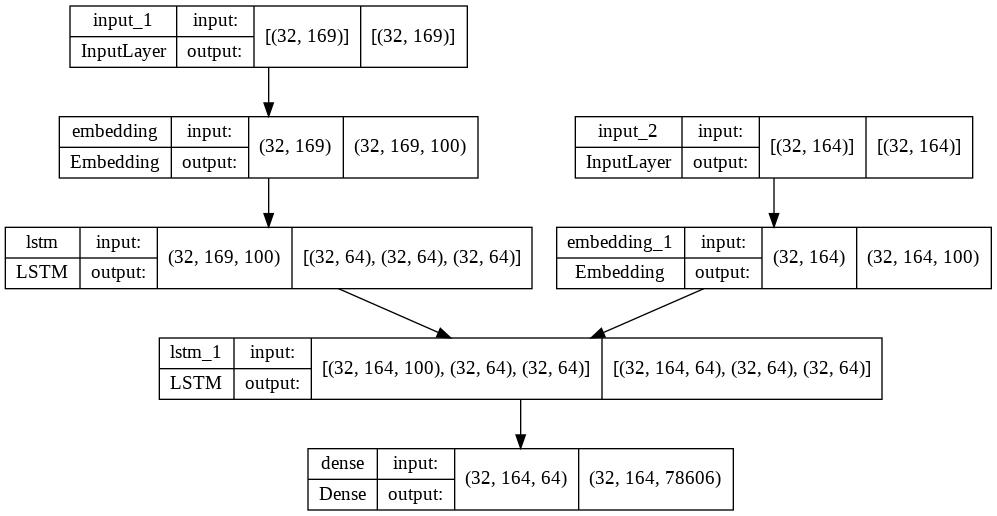

In [21]:
tf.keras.utils.plot_model(model, to_file='img.png', show_shapes=True)

In [53]:
re_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(32, 169)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(32, 164)]          0           []                               
                                                                                                  
 embedding (Embedding)          (32, 169, 100)       3583200     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (32, 164, 100)       7860600     ['input_2[0][0]']                
                                                                                            

In [46]:
model.layers[0]

In [47]:
# MODEL RECONSTRUCTION

"""------------------------------ENCODER------------------------------
"""
enc_inputs = model.input[0]
enc_embed = model.layers[2](enc_inputs)
enc_outputs, state_h, state_c  = model.layers[4](enc_embed)
encoder_states = [state_h,state_c]

"""------------------------------DECODER------------------------------
"""
dec_inputs =model.input[1]
dec_embed  = model.layers[3](dec_inputs)
dec_output,dec_h,dec_c  = model.layers[5](dec_embed,initial_state=encoder_states)
dec_outputs = model.layers[6](dec_output)

"""------------------------------COMPILE------------------------------
"""
re_model = tf.keras.Model([enc_inputs,dec_inputs],dec_outputs)
# re_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

In [64]:
latent_dim = 64
word_dim = 100
encoder_model = tf.keras.Model(enc_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = tf.keras.Input(shape=(latent_dim,))
decoder_state_input_c = tf.keras.Input(shape=(latent_dim,))

decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_embed = model.layers[3](dec_inputs)
dec_output,dec_h,dec_c = model.layers[5](dec_embed,initial_state=decoder_states_inputs)
dec_hidden_and_cell = [dec_h,dec_c]

dec_dense_out = model.layers[6](dec_output)
dec_model = tf.keras.Model(
    [dec_inputs] + decoder_states_inputs,
    [dec_dense_out] + dec_hidden_and_cell
)

In [68]:
dec_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(32, 164)]          0           []                               
                                                                                                  
 embedding_3 (Embedding)        (32, 164, 100)       7860600     ['input_8[0][0]']                
                                                                                                  
 input_9 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 64)]         0           []                               
                                                                                            

In [106]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']
    
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output_tokens, h, c = dec_model.predict([target_seq] + states_value)
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char
        
        # Exit condition: either hit max length or find stop token.
        if (sampled_char == '_END' or len(decoded_sentence) > 50):
            stop_condition = True
        
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        
        # Update states
        states_value = [h, c]
    
    return decoded_sentence

In [209]:
train_gen = generate_batch(X_train, y_train, batch_size = 32)
k=-1
(input_seq, actual_output), _ = next(train_gen)
k+=1

In [217]:
target_seq = np.zeros((32,1))
for idx,row in enumerate(target_seq):
  target_seq[idx][0] = target_token_index['START_']
pred = encoder_model.predict(input_seq)

stop_condition = False
decoded_sentence = ['']*32
while not stop_condition:
        output_tokens, h, c = dec_model.predict([target_seq] + pred)
        # Sample a token
        target_seq = np.zeros((32,1))
        for idx in range(32):
          sampled_token_index = np.argmax(output_tokens[idx, -1, :])
          sampled_char = reverse_target_char_index[sampled_token_index]
          decoded_sentence[idx] += ' '+sampled_char

          target_seq[idx, 0] = sampled_token_index
          if ( len(decoded_sentence[idx]) > 150):
            stop_condition = True

        states_value = [h, c]

In [ ]:
for idx in range(32):
  print('Input English sentence:', X_train[k:k+32].values[idx])
  print('Actual Assamese Translation:', y_train[k:k+32].values[idx])
  print('Predicted Assamese Translation:', decoded_sentence[idx])
  print("\n \n")